In [1]:
import os
import time
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset

In [2]:
# Check for GPU availability
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple Metal Performance Shaders (MPS)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use CUDA if available (for NVIDIA GPUs)
else:
    device = torch.device("cpu")  # Fallback to CPU

In [3]:
# CNN Model
class MalariaCNN(nn.Module):
    def __init__(self):
        super(MalariaCNN, self).__init__()
        
        # First Conv Block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.LeakyReLU(0.01)
        self.pool1 = nn.MaxPool2d(2)
        self.drop1 = nn.Dropout(0.25)

        # Second Conv Block
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.LeakyReLU(0.01)
        self.pool2 = nn.MaxPool2d(2)
        self.drop2 = nn.Dropout(0.3)

        # Third Conv Block
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.LeakyReLU(0.01)
        self.pool3 = nn.MaxPool2d(2)
        self.drop3 = nn.Dropout(0.4)

        # Fourth Conv Block
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.LeakyReLU(0.01)
        self.pool4 = nn.MaxPool2d(2)
        self.drop4 = nn.Dropout(0.5)

        # Fully Connected Layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.LeakyReLU(0.01)
        self.drop5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 2)  # Output: 2 classes (parasitized vs uninfected)

    def forward(self, x):
        x = self.pool1(self.drop1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.drop2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.drop3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.drop4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.drop5(self.relu5(self.bn5(self.fc1(x))))
        x = self.fc2(x)
        return x

In [4]:
# Initialize Model
model = MalariaCNN().to(device)
print(model)

MalariaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0

In [5]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(64, scale=(0.9, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset
train_dataset = datasets.ImageFolder(root="/Users/Scott/Desktop/MIT Applied Data Science /Capstone/cell_images/train", transform=transform_train)
test_dataset = datasets.ImageFolder(root="/Users/Scott/Desktop/MIT Applied Data Science /Capstone/cell_images/test", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


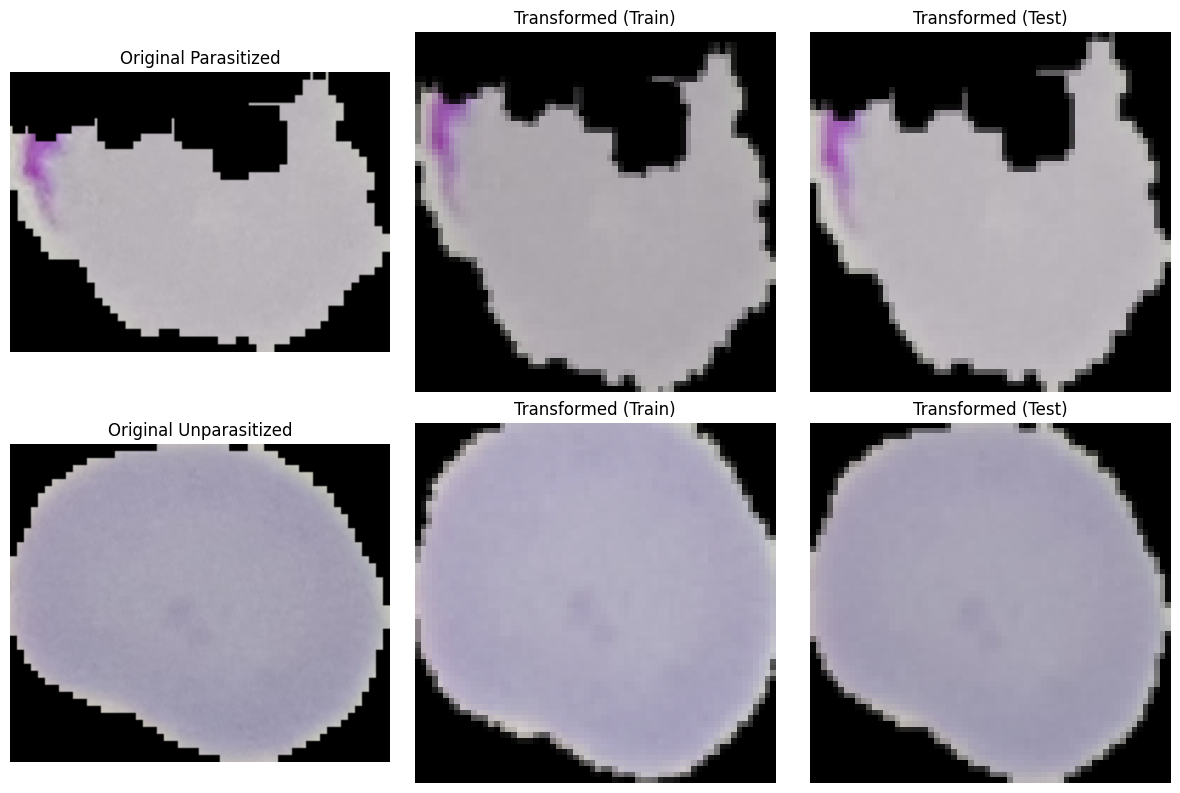

In [6]:

train_dataset_path = "/Users/Scott/Desktop/MIT Applied Data Science/Capstone/cell_images/train"

def get_random_image(class_path):
    image_filename = random.choice(os.listdir(class_path))  # Pick a random image
    image_path = os.path.join(class_path, image_filename)
    image = Image.open(image_path).convert("RGB")  # Ensure RGB format
    return image, image_path

# Get random images from both classes
parasitized_image, parasitized_path = get_random_image("/Users/Scott/Desktop/MIT Applied Data Science /Capstone/cell_images/train/parasitized")
unparasitized_image, unparasitized_path = get_random_image("/Users/Scott/Desktop/MIT Applied Data Science /Capstone/cell_images/train/uninfected")

# Apply transformations
transformed_parasitized_train = transform_train(parasitized_image)
transformed_unparasitized_train = transform_train(unparasitized_image)

transformed_parasitized_test = transform_test(parasitized_image)
transformed_unparasitized_test = transform_test(unparasitized_image)

# Function to convert tensor to displayable image
def tensor_to_image(tensor):
    tensor = tensor.numpy().transpose(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    tensor = (tensor * 0.5) + 0.5  # Undo normalization
    return np.clip(tensor, 0, 1)  # Ensure values are in range [0,1]

# Display images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Parasitized Images
axes[0, 0].imshow(parasitized_image)
axes[0, 0].set_title("Original Parasitized")
axes[0, 0].axis("off")

axes[0, 1].imshow(tensor_to_image(transformed_parasitized_train))
axes[0, 1].set_title("Transformed (Train)")
axes[0, 1].axis("off")

axes[0, 2].imshow(tensor_to_image(transformed_parasitized_test))
axes[0, 2].set_title("Transformed (Test)")
axes[0, 2].axis("off")

# Unparasitized Images
axes[1, 0].imshow(unparasitized_image)
axes[1, 0].set_title("Original Unparasitized")
axes[1, 0].axis("off")

axes[1, 1].imshow(tensor_to_image(transformed_unparasitized_train))
axes[1, 1].set_title("Transformed (Train)")
axes[1, 1].axis("off")

axes[1, 2].imshow(tensor_to_image(transformed_unparasitized_test))
axes[1, 2].set_title("Transformed (Test)")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [7]:
#checking if dataset is imbalanced
# Count samples per class
train_counts = Counter([label for _, label in train_dataset.samples])
test_counts = Counter([label for _, label in test_dataset.samples])

print("Train Class Distribution:", train_counts)
print("Test Class Distribution:", test_counts)


Train Class Distribution: Counter({0: 12582, 1: 12376})
Test Class Distribution: Counter({0: 1300, 1: 1300})


In [8]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler (Reduce LR on Plateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, verbose=True)


/opt/anaconda3/envs/malaria_env/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# Training loop
num_epochs = 30
best_val_loss = float("inf")

for epoch in range(num_epochs):
    start_time = time.time()  # Start timing

    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_accuracy = correct / total
    val_loss = 0.0
    val_correct, val_total = 0, 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / val_total
    scheduler.step(val_loss)  # Adjust learning rate if needed

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_accuracy:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_malaria_cnn.pth")
        print(f"---Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}---")

epoch_time = time.time() - start_time  # End timing
print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} sec")


Epoch [1/30], Train Loss: 0.3115, Train Acc: 0.8584, Val Loss: 1.3200, Val Acc: 0.5273
---Model saved at epoch 1 with val_loss: 108.2416---
Epoch [2/30], Train Loss: 0.1346, Train Acc: 0.9519, Val Loss: 0.8213, Val Acc: 0.6469
---Model saved at epoch 2 with val_loss: 67.3463---
Epoch [3/30], Train Loss: 0.1048, Train Acc: 0.9643, Val Loss: 0.5578, Val Acc: 0.7496
---Model saved at epoch 3 with val_loss: 45.7393---
Epoch [4/30], Train Loss: 0.0912, Train Acc: 0.9702, Val Loss: 0.5327, Val Acc: 0.7631
---Model saved at epoch 4 with val_loss: 43.6830---
Epoch [5/30], Train Loss: 0.0841, Train Acc: 0.9734, Val Loss: 0.4601, Val Acc: 0.8081
---Model saved at epoch 5 with val_loss: 37.7278---
Epoch [6/30], Train Loss: 0.0814, Train Acc: 0.9748, Val Loss: 0.4071, Val Acc: 0.8227
---Model saved at epoch 6 with val_loss: 33.3862---
Epoch [7/30], Train Loss: 0.0760, Train Acc: 0.9752, Val Loss: 0.2285, Val Acc: 0.9069
---Model saved at epoch 7 with val_loss: 18.7356---
Epoch [8/30], Train Loss: 

In [10]:
# Load best model
model.load_state_dict(torch.load("best_malaria_cnn.pth"))
model.eval()

# Compute test accuracy
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9369


Introduce Partial Fine-Tuning

In [11]:
for param in model.conv1.parameters():  # Freeze 1st convolutional layer
    param.requires_grad = False

for param in model.conv2.parameters():  # Freeze 2nd convolutional layer
    param.requires_grad = False

# Fine-Tune Only Last Conv Layer and Fully Connected Layers
for param in model.conv3.parameters():  # Fine-tune 3rd conv layer
    param.requires_grad = True

for param in model.fc1.parameters():  # Fine-tune fully connected layers
    param.requires_grad = True

for param in model.fc2.parameters():  # Fine-tune output layer
    param.requires_grad = True

# Move to GPU/MPS (if available)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MalariaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0

Optimizer for Fine-Tuning Only Selected Layers

In [12]:
# Define loss function
criterion = nn.CrossEntropyLoss()

# Optimize fine-tuned layers
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  #ensures only trainable parameters are updated.
    lr=1e-4) #lowering the learning rate prevents drastic changes

# Learning Rate Scheduler (Optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)


Training Loop for Fine-Tuning

In [13]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_epochs = 10  # Fine-tune for a few epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Train Acc: {train_accuracy:.4f}")
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Save only if validation loss improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "fine_tuned_model.pth")  
        print(f"---Model saved at epoch {epoch+1} with val_loss: {val_loss:.4f}---")

print("Fine-Tuning Complete")


Epoch 1/10, Loss: 50.3434, Train Acc: 0.9785
Epoch 2/10, Loss: 49.0175, Train Acc: 0.9792
Epoch 3/10, Loss: 48.1047, Train Acc: 0.9799
Epoch 4/10, Loss: 52.2067, Train Acc: 0.9780
Epoch 5/10, Loss: 52.5657, Train Acc: 0.9780
Epoch 6/10, Loss: 52.5583, Train Acc: 0.9780
Epoch 7/10, Loss: 53.1815, Train Acc: 0.9783
Epoch 8/10, Loss: 56.4507, Train Acc: 0.9782
Epoch 9/10, Loss: 55.7081, Train Acc: 0.9773
Epoch 10/10, Loss: 55.2898, Train Acc: 0.9777
Fine-Tuning Complete


In [14]:
# Load best model
model.load_state_dict(torch.load("fine_tuned_model.pth"))
model.eval()

# Compute test accuracy
test_correct, test_total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9581
